In [ ]:
!pip install python-binance
!pip install binance-client

# Simple Binance Data Fetch

In [ ]:
import binance.client
import pandas as pd
import numpy as np
import time
import os
import requests
from pprint import pprint
import subprocess
import datetime as dt
import json
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from tqdm import tqdm

class BinanceClient():

    INTERVAL_1MINUTE = binance.client.Client.KLINE_INTERVAL_1MINUTE

    column_names = ['open_time',
            'open',
            'high',
            'low',
            'close',
            'vol',
            'close_time',
            'quote_asset_volume',
            'number_of_trades',
            'taker_buy_base_asset_volume',
            'taker_buy_quote_asset_volume',
            'ignore']

    def __init__(self, api_key, api_secret):
        self.client = binance.client.Client(api_key, api_secret)

    def polish_kline(self, raw_kline):
        kline_d =  {'open_time':    raw_kline[0],
                    'open':         raw_kline[1],
                    'close':        raw_kline[2],
                    'low':          raw_kline[3],
                    'high':         raw_kline[4],
                    'vol':          raw_kline[5]}
        kline_d['open_datetime'] = pd.to_datetime(kline_d['open_time'], unit='ms')
        return kline_d

    def historical_klines_generator(self, instrument, interval, start_dt, end_dt=None):
        for kline in self.client.get_historical_klines_generator(instrument, interval, str(start_dt), str(end_dt) if end_dt else None):
            yield self.polish_kline(kline)


In [ ]:
api_key = "vT0XoiF4FbrpHbH04ZEew6A9jOORd79J4RdmId0CTT6wwX97EuY9hPCBcp9F904f"
api_secret = "wcpF4Ne1tNGbq5vPx2oaXrpbE2JnNXhn6tKV6I32uKNdBMuEazRfDPiMJkIVqVr8"
        

In [ ]:
client = BinanceClient(api_key, api_secret)

start_date = dt.datetime(2021,11,7,10,0,0)
instrument = "BTCUSDT"

kline_df = pd.DataFrame(columns=["open","high","low","close","vol"])
for kline in client.historical_klines_generator(instrument, BinanceClient.INTERVAL_1MINUTE, start_date): 
    kline_df.loc[kline['open_datetime']] = (kline["open"], kline["high"], kline["low"], kline["close"], kline["vol"])

In [ ]:
kline_df

open  ...          vol
2021-11-07 10:00:00  61970.75000000  ...  14.15675000
2021-11-07 10:01:00  61973.80000000  ...  23.43820000
2021-11-07 10:02:00  62020.00000000  ...  28.45315000
2021-11-07 10:03:00  62001.38000000  ...  29.18175000
2021-11-07 10:04:00  61979.75000000  ...  31.51528000
...                             ...  ...          ...
2021-11-22 22:51:00  56573.13000000  ...  25.52704000
2021-11-22 22:52:00  56582.18000000  ...  22.82956000
2021-11-22 22:53:00  56567.20000000  ...  22.31095000
2021-11-22 22:54:00  56567.24000000  ...  16.28050000
2021-11-22 22:55:00  56665.16000000  ...  11.43390000

[22376 rows x 5 columns]

# Simple ML

In [ ]:
ml_df = pd.DataFrame()
for i in range(60):
  ml_df[f"t_{i}"] = kline_df.close.shift(i)

In [ ]:
ml_df = ml_df.dropna().astype(float)

In [ ]:
ml_df

t_0       t_1       t_2  ...      t_57      t_58      t_59
2021-11-07 10:59:00  61944.58  61918.98  61922.24  ...  62054.33  62020.00  62001.85
2021-11-07 11:00:00  61949.97  61944.58  61918.98  ...  62010.96  62054.33  62020.00
2021-11-07 11:01:00  61950.00  61949.97  61944.58  ...  62058.73  62010.96  62054.33
2021-11-07 11:02:00  61936.09  61950.00  61949.97  ...  62320.54  62058.73  62010.96
2021-11-07 11:03:00  61876.33  61936.09  61950.00  ...  62350.00  62320.54  62058.73
...                       ...       ...       ...  ...       ...       ...       ...
2021-11-22 22:51:00  56601.97  56687.69  56706.57  ...  56198.91  56196.64  56197.67
2021-11-22 22:52:00  56597.74  56601.97  56687.69  ...  56211.93  56198.91  56196.64
2021-11-22 22:53:00  56584.84  56597.74  56601.97  ...  56256.63  56211.93  56198.91
2021-11-22 22:54:00  56674.98  56584.84  56597.74  ...  56275.52  56256.63  56211.93
2021-11-22 22:55:00  56669.26  56674.98  56584.84  ...  56280.00  56275.52  56256.63

[22317 rows x 60 columns]

## Backtesting

In [ ]:
boll_df = pd.DataFrame(index=kline_df.index)
boll_df["price"] = kline_df.close.astype(float)

In [ ]:
initial_hist = boll_df.iloc[:300]

## Kalman Filter

![](https://i.imgur.com/xW57MbJ.png)

In [ ]:
class KalmanFilterConstant:
    def __init__(self, initial_value_estimate, initial_value_estimate_uncertainty, value_process_noise,
                 ):
        self.x = [initial_value_estimate]
        self.p_x = [initial_value_estimate_uncertainty]
        self.q_x = value_process_noise
        self.x_extrapolation = [self.x[-1]]
        self.p_x_extrapolation = [self.p_x[-1] + self.q_x]
        self.measurements = []
        self.kalman_gain = []

    def update(self, measurement, measurement_noise):
        self.measurements.append(measurement)
        kalman_gain = self.p_x_extrapolation[-1] / (self.p_x_extrapolation[-1] + measurement_noise)
        self.kalman_gain.append(kalman_gain)
        x = self.x_extrapolation[-1] + kalman_gain * (measurement - self.x_extrapolation[-1])
        self.x.append(x)
        p_x = (1 - kalman_gain)*self.p_x_extrapolation[-1]
        self.p_x.append(p_x)

    def predict(self, measurement, measurement_noise):
        self.x_extrapolation.append(self.x[-1])
        self.p_x_extrapolation.append(self.p_x[-1] + self.q_x)

    def timeStep(self, measurement, measurement_noise):
        self.update(measurement, measurement_noise)
        self.predict(measurement, measurement_noise)

    def plotKalmanGain(self):
        plt.figure(figsize=(16, 9))
        plt.plot(self.kalman_gain)
        plt.show()
    
    def plotExtrapolationVsMeasurement(self):
        plt.figure(figsize=(16, 9))
        plt.plot(self.measurements, )
        plt.plot(self.x[1:])
        plt.legend(["Measurements", "Estimations"])
        plt.show()

In [ ]:
process_noise_std = 10
measurement_noise = 5
value_estimate_uncertainty = 500
kalman = KalmanFilterConstant(62000, 500**2, process_noise_std**2)
for id, entry in boll_df.iloc[:300].iterrows():
    sample = pd.DataFrame([entry], index=[id])
    kalman.timeStep(sample.price.to_numpy()[0], measurement_noise**2)

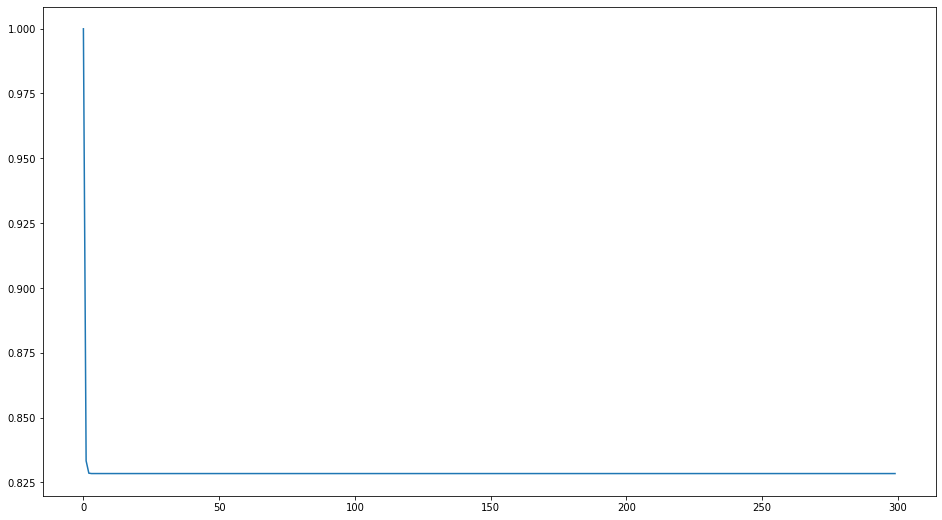

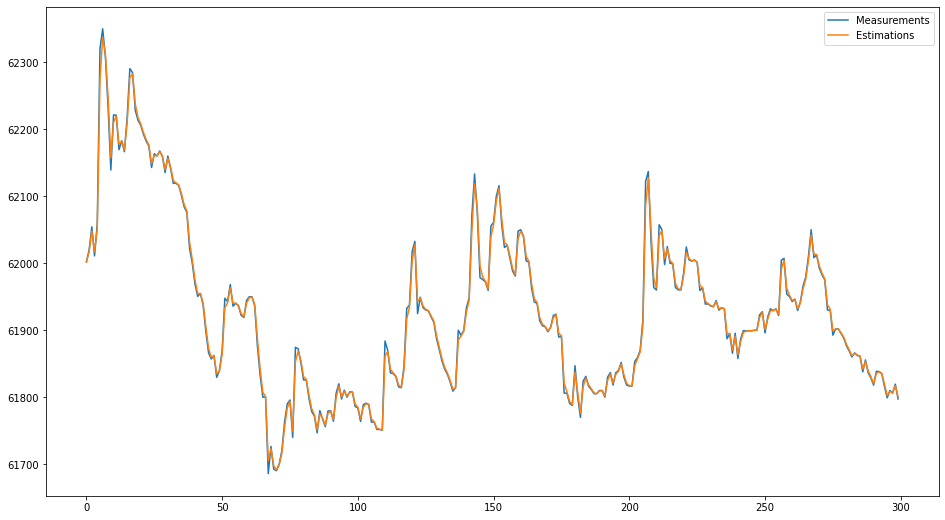

In [ ]:
kalman.plotKalmanGain()
kalman.plotExtrapolationVsMeasurement()

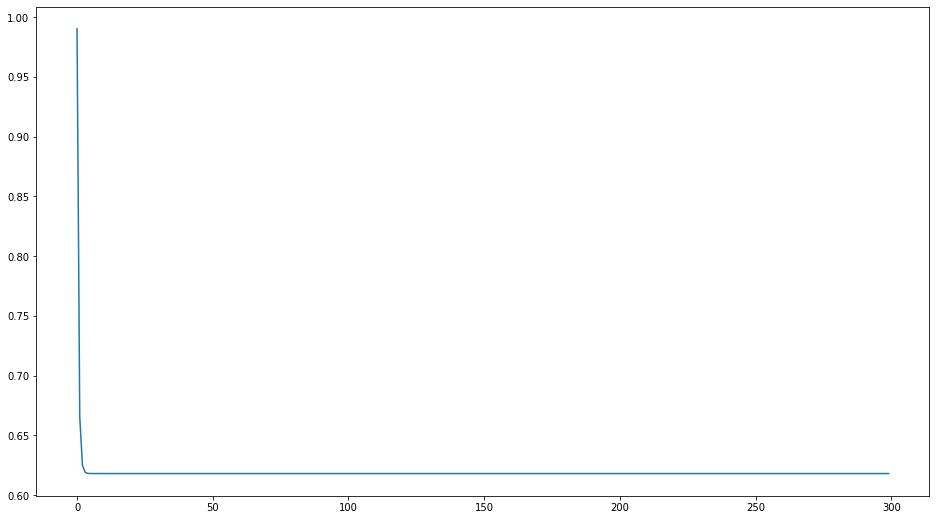

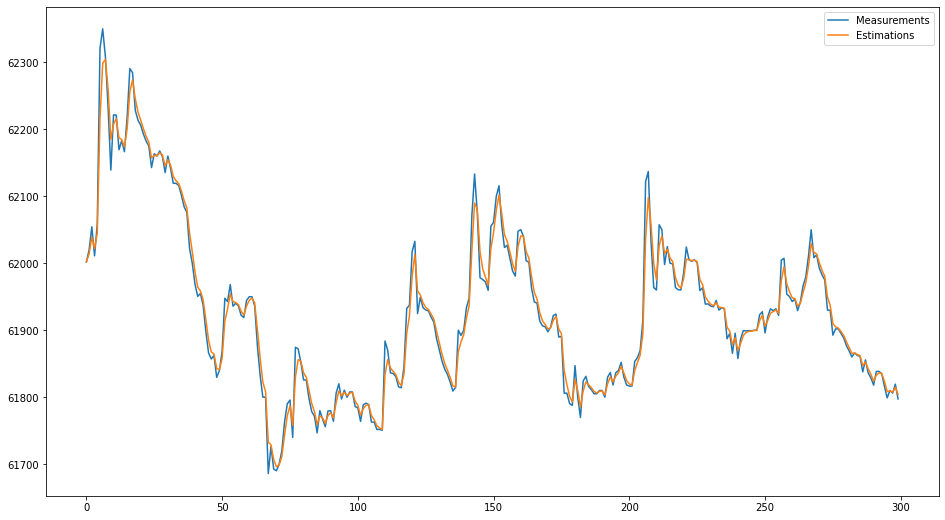

In [ ]:
process_noise_std = 50
measurement_noise = 50
value_estimate_uncertainty = 500
kalman = KalmanFilterConstant(62000, 500**2, process_noise_std**2)
for id, entry in boll_df.iloc[:300].iterrows():
    sample = pd.DataFrame([entry], index=[id])
    kalman.timeStep(sample.price.to_numpy()[0], measurement_noise**2)
kalman.plotKalmanGain()
kalman.plotExtrapolationVsMeasurement()

In [ ]:
# class KalmanFilterConstantVelocity:
#     def __init__(self, initial_value_estimate, initial_value_estimate_uncertainty, value_process_noise,
#                  initial_velocity_estimate, initial_velocity_estimate_uncertainty, value_velocity_noise,
#                  ):
#         self.x = [initial_value_estimate]
#         self.p_x = [initial_value_estimate_uncertainty]
#         self.q_x = value_process_noise
#         self.v = [initial_velocity_estimate]
#         self.
#         self.x_extrapolation = [self.x[-1] + self.v[-1]]
#         self.p_x_extrapolation = [self.p_x[-1] + self.q_x]
#         self.measurements = []
#         self.kalman_gain = []

#     def update(self, measurement, measurement_noise):
#         self.measurements.append(measurement)
#         kalman_gain = self.p_x_extrapolation[-1] / (self.p_x_extrapolation[-1] + measurement_noise)
#         self.kalman_gain.append(kalman_gain)
#         x = self.x_extrapolation[-1] + kalman_gain * (measurement - self.x_extrapolation[-1])
#         self.x.append(x)
#         p_x = (1 - kalman_gain)*self.p_x_extrapolation[-1]
#         self.p_x.append(p_x)

#     def predict(self, measurement, measurement_noise):
#         self.x_extrapolation.append(self.x[-1])
#         self.p_x_extrapolation.append(self.p_x[-1] + self.q_x)

#     def timeStep(self, measurement, measurement_noise):
#         self.update(measurement, measurement_noise)
#         self.predict(measurement, measurement_noise)

#     def plotKalmanGain(self):
#         plt.figure(figsize=(16, 9))
#         plt.plot(self.kalman_gain)
#         plt.show()

#     def plotExtrapolationVsMeasurement(self):
#         plt.figure(figsize=(16, 9))
#         plt.plot(self.measurements, )
#         plt.plot(self.x_extrapolation[:-1])
#         plt.legend(["Measurements", "Estimations"])
#         plt.show()

![](https://i.imgur.com/TFsvHE4.png)
![](https://i.imgur.com/S3nxIwr.png)
![](https://i.imgur.com/ESWuYac.png)
![](https://i.imgur.com/o53Xs5s.png)
![](https://i.imgur.com/YD3Phtq.png)


In [ ]:
class KalmanFilter:
    def __init__(self, initial_state, state_uncertainty, sigma_acceleration, process_noise=0.0):
        self.state_transition_matrix = np.array([[1.0, 1.0, 0.5],[0.0, 1.0, 1.0], [0.0, 0.0, 1.0]])
        self.input_transition_matrix = None
        # self.process_noise = process_noise
        self.process_noise_matrix = np.array([[0.25, 0.5, 0.5], [0.5, 1., 1.], [0.5, 1., 1.]]) * sigma_acceleration
        self.last_state = initial_state
        self.last_predicted_state = None
        self.last_state_uncertainty = state_uncertainty
        self.last_prediction_uncertainty = None
        # self.last_predicted_state = np.array()
        self.predicted_states = []
        self.prediction_uncertainties = []
        self.observation_matrix = np.array([[1.0, 0.0, 0.0]])
        # self.observation_matrix = 1.0
        self.measurements = []
        self.state_history = []
        self.kalman_gain_history = []

    def predict(self, measurement, measurement_noise):
        self.measurements.append(measurement)
        # state extrapolation equation
        # self.last_predicted_state = self.state_transition_matrix @ self.last_state + \
        #             self.input_transition_matrix @ measurement + self.process_noise
        self.last_predicted_state = self.state_transition_matrix @ self.last_state
        self.predicted_states.append(self.last_predicted_state)
        # covariance extrapolation equation
        self.last_prediction_uncertainty = self.state_transition_matrix @ self.last_state_uncertainty @ \
                    self.state_transition_matrix.T + self.process_noise_matrix
        self.prediction_uncertainties.append(self.last_prediction_uncertainty)
        # measurement equation


    def correct(self, measurement, measurement_noise):
        # kalman gain
        temp = self.observation_matrix @ self.last_prediction_uncertainty @ self.observation_matrix.T + measurement_noise
        if type(temp) is np.ndarray:
            self.kalman_gain = self.last_prediction_uncertainty @ self.observation_matrix.T @ np.linalg.inv(temp)
        else:
            self.kalman_gain = self.last_prediction_uncertainty @ self.observation_matrix.T * (1/temp)
        self.kalman_gain_history.append(self.kalman_gain)
        
        # state update
        self.last_state = self.last_predicted_state + self.kalman_gain @ (measurement - self.observation_matrix @ self.last_predicted_state)
        self.state_history.append(self.last_state[0,:])

        # state uncertainty
        temp = self.kalman_gain @ self.observation_matrix
        I = np.diag(np.ones(temp.shape[0]))
        if type(measurement_noise) is np.ndarray:
            self.last_state_uncertainty = (I - temp) @ self.last_prediction_uncertainty @ (I - temp).T + \
                self.kalman_gain @ measurement_noise @ self.kalman_gain.T
        else:
            self.last_state_uncertainty = (I - temp) @ self.last_prediction_uncertainty @ (I - temp).T + \
                self.kalman_gain @ self.kalman_gain.T * measurement_noise


    def timeStep(self, measurement, measurement_noise):
        self.predict(measurement, measurement_noise)
        self.correct(measurement, measurement_noise)

    def plotKalmanGain(self):
        plt.figure(figsize=(16, 9))
        plt.plot(np.array(self.kalman_gain_history)[:, 0, 0])
        plt.show()

    def plotExtrapolationVsMeasurement(self):
        plt.figure(figsize=(16, 9))
        plt.plot(self.measurements, )
        plt.plot(np.array(self.state_history)[:, 0])
        # print(len(self.measurements), len(self.predictions_history))
        plt.legend(["Measurements", "Estimations"])
        plt.show()

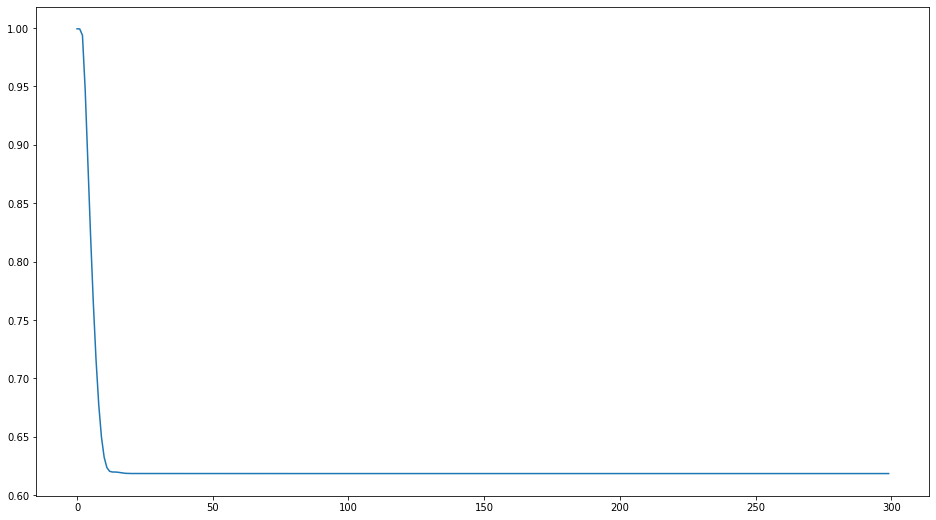

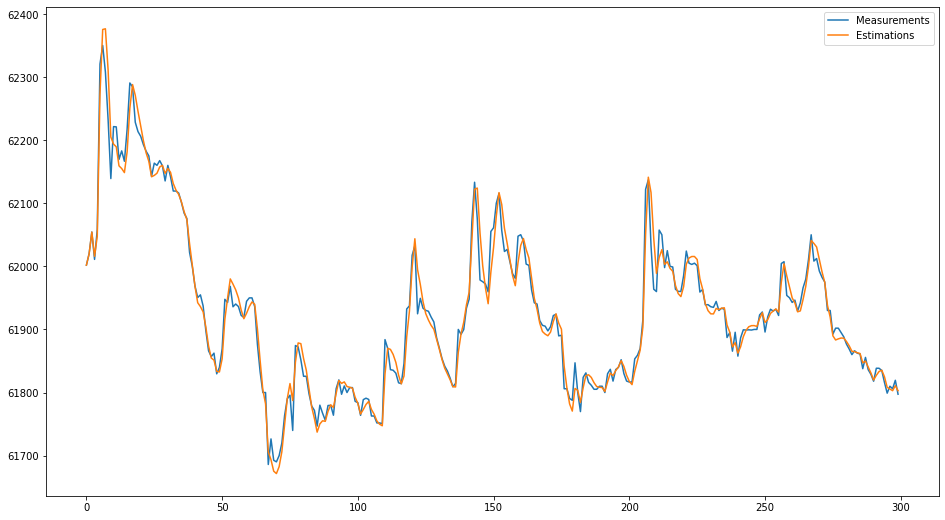

In [ ]:
sigma_acc = 5.0
measurement_noise = 20
process_noise = 0
x0 = np.array([[62000, 0, 0]]).T
P0 = np.array([[500**2, 0.0, 0.0], [0.0, 500**2, 0.0], [0.0, 0.0, 500**2]])
kalman = KalmanFilter(x0, P0, sigma_acc, process_noise)
for id, entry in boll_df.iloc[:300].iterrows():
    sample = pd.DataFrame([entry], index=[id])
    kalman.timeStep(sample.price.to_numpy()[0], measurement_noise**2)
kalman.plotKalmanGain()
kalman.plotExtrapolationVsMeasurement()

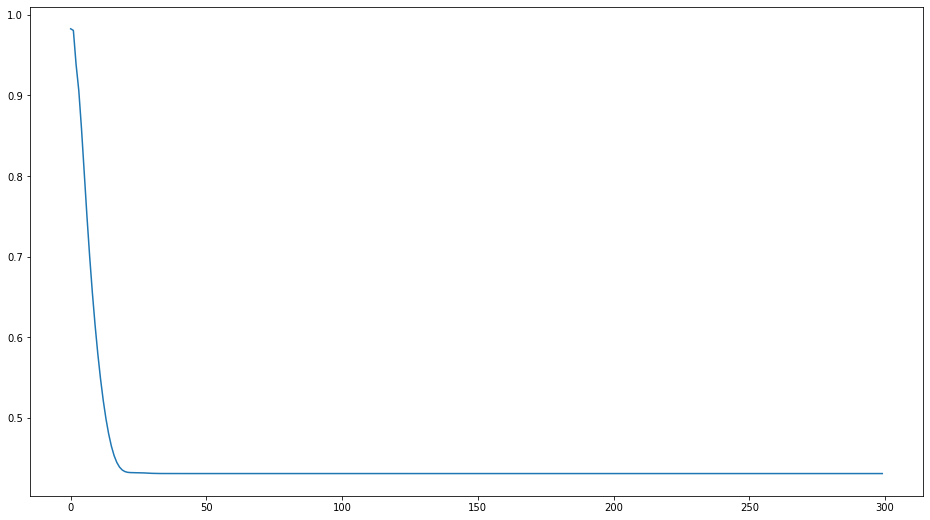

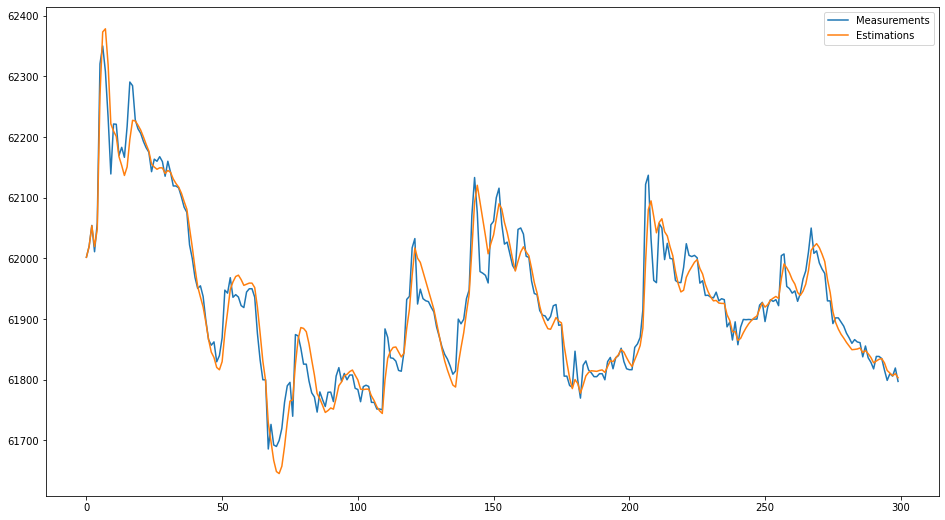

In [ ]:
sigma_acc = 5.0
measurement_noise = 100
process_noise = 0
x0 = np.array([[62000, 0, 0]]).T
P0 = np.array([[500**2, 0.0, 0.0], [0.0, 500**2, 0.0], [0.0, 0.0, 500**2]])
kalman = KalmanFilter(x0, P0, sigma_acc, process_noise)
for id, entry in boll_df.iloc[:300].iterrows():
    sample = pd.DataFrame([entry], index=[id])
    kalman.timeStep(sample.price.to_numpy()[0], measurement_noise**2)
kalman.plotKalmanGain()
kalman.plotExtrapolationVsMeasurement()

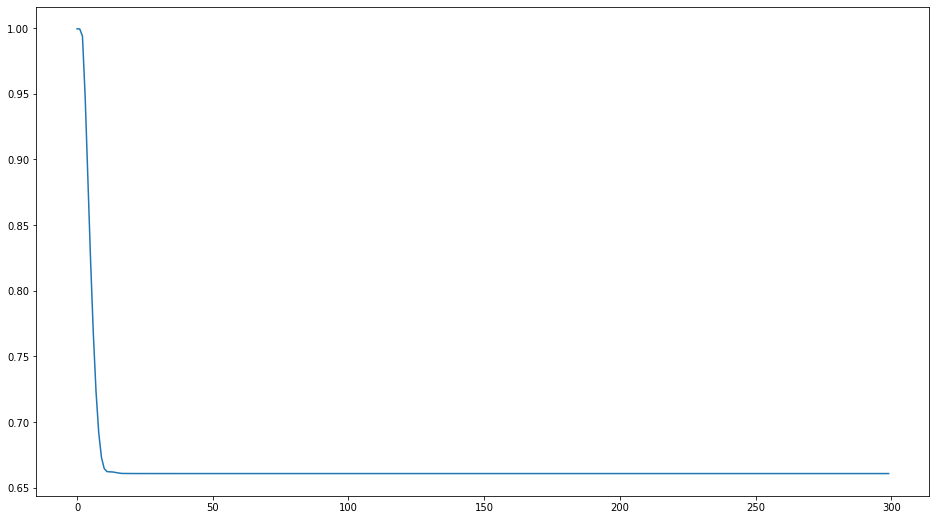

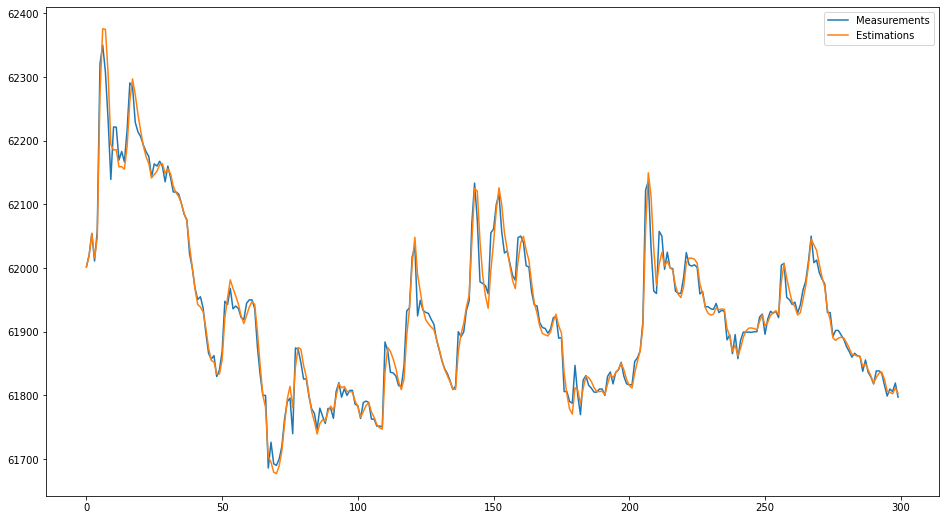

In [ ]:
sigma_acc = 10.0
measurement_noise = 20
process_noise = 0
x0 = np.array([[62000, 0, 0]]).T
P0 = np.array([[500**2, 0.0, 0.0], [0.0, 500**2, 0.0], [0.0, 0.0, 500**2]])
kalman = KalmanFilter(x0, P0, sigma_acc, process_noise)
for id, entry in boll_df.iloc[:300].iterrows():
    sample = pd.DataFrame([entry], index=[id])
    kalman.timeStep(sample.price.to_numpy()[0], measurement_noise**2)
kalman.plotKalmanGain()
kalman.plotExtrapolationVsMeasurement()

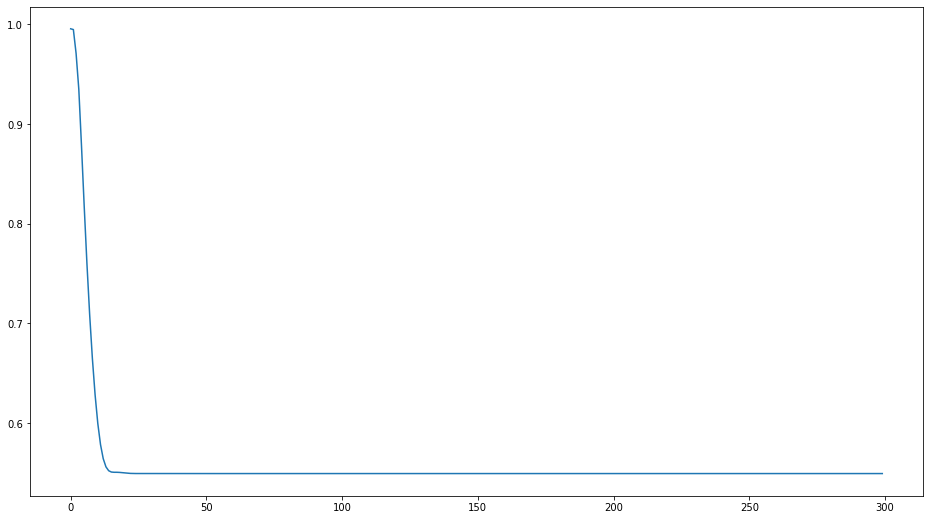

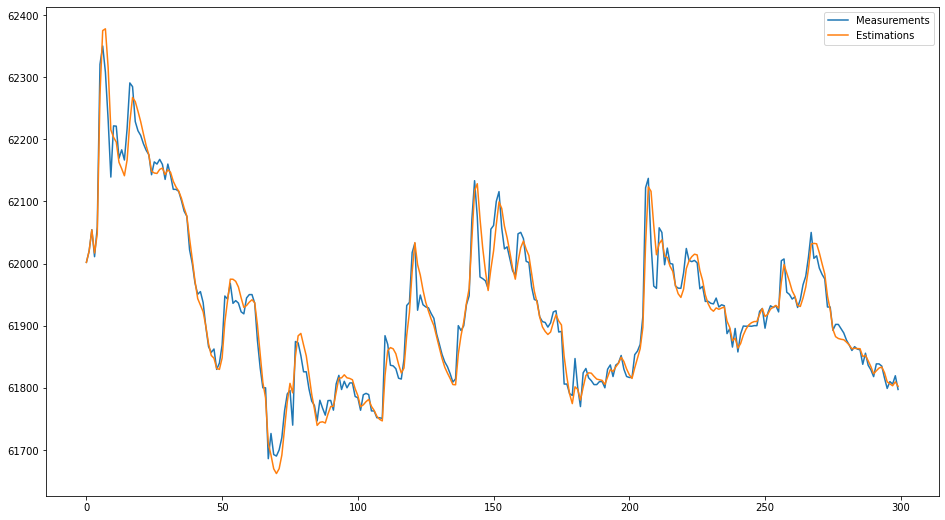

In [ ]:
sigma_acc = 10.0
measurement_noise = 50
process_noise = 0
x0 = np.array([[62000, 0, 0]]).T
P0 = np.array([[500**2, 0.0, 0.0], [0.0, 500**2, 0.0], [0.0, 0.0, 500**2]])
kalman = KalmanFilter(x0, P0, sigma_acc, process_noise)
for id, entry in boll_df.iloc[:300].iterrows():
    sample = pd.DataFrame([entry], index=[id])
    kalman.timeStep(sample.price.to_numpy()[0], measurement_noise**2)
kalman.plotKalmanGain()
kalman.plotExtrapolationVsMeasurement()

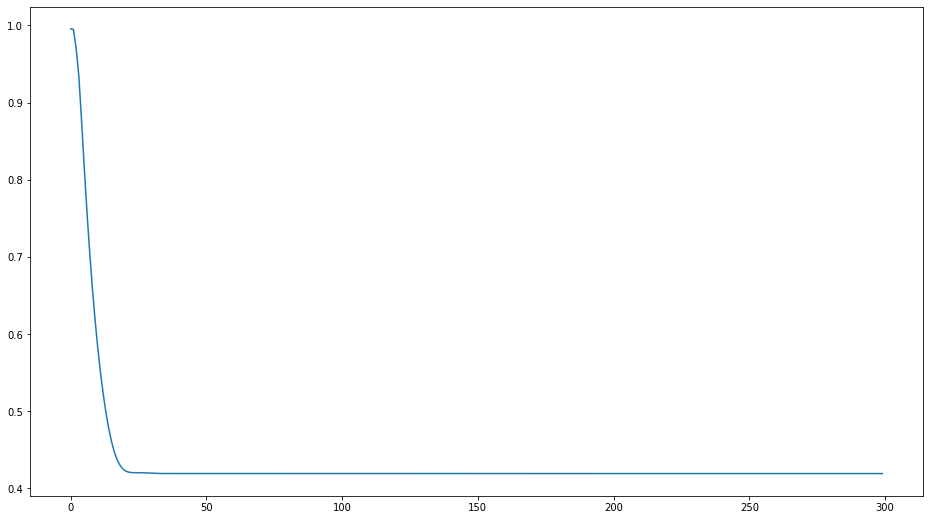

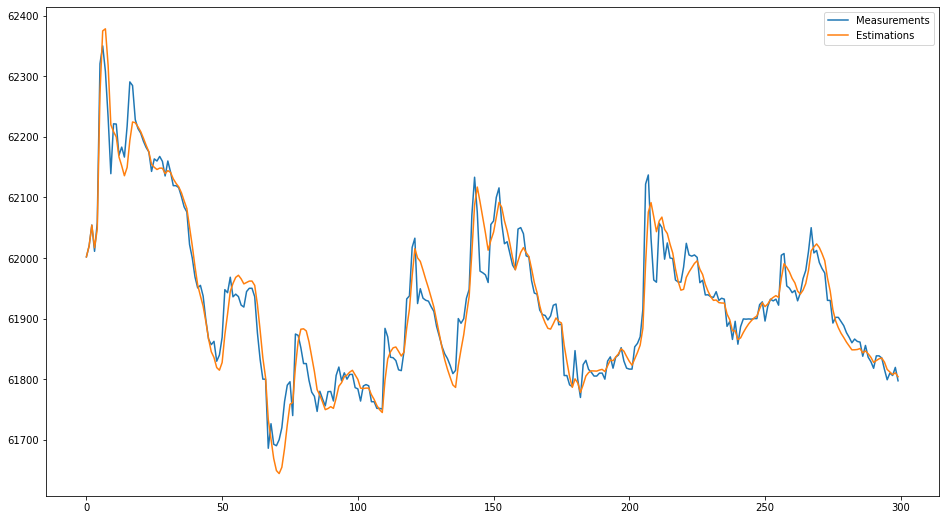

In [ ]:
sigma_acc = 1.0
measurement_noise = 50
process_noise = 0
x0 = np.array([[62000, 0, 0]]).T
P0 = np.array([[500**2, 0.0, 0.0], [0.0, 500**2, 0.0], [0.0, 0.0, 500**2]])
kalman = KalmanFilter(x0, P0, sigma_acc, process_noise)
for id, entry in boll_df.iloc[:300].iterrows():
    sample = pd.DataFrame([entry], index=[id])
    kalman.timeStep(sample.price.to_numpy()[0], measurement_noise**2)
kalman.plotKalmanGain()
kalman.plotExtrapolationVsMeasurement()

In [ ]:
import plotly.graph_objects as go

sigma_acc = 1.0
measurement_noise = 200
process_noise = 0
x0 = np.array([[62000, 0, 0]]).T
P0 = np.array([[500**2, 0.0, 0.0], [0.0, 500**2, 0.0], [0.0, 0.0, 500**2]])
kalman = KalmanFilter(x0, P0, sigma_acc, process_noise)
for id, entry in boll_df.iterrows():
    sample = pd.DataFrame([entry], index=[id])
    kalman.timeStep(sample.price.to_numpy()[0], measurement_noise**2)
args = np.arange(len(boll_df))
fig = go.Figure()
fig.add_trace(go.Scatter(x=args, y=kalman.measurements, mode="lines", name="Ground Truth"))
fig.add_trace(go.Scatter(x=args, y=np.array(kalman.state_history)[:, 0], mode="lines", line=dict(color="firebrick"), name="Kalman estimation"))


fig.show()

In [ ]:
import plotly.graph_objects as go

sigma_acc = 1.0
measurement_noise = 1000
process_noise = 0
x0 = np.array([[62000, 0, 0]]).T
P0 = np.array([[500**2, 0.0, 0.0], [0.0, 500**2, 0.0], [0.0, 0.0, 500**2]])
kalman = KalmanFilter(x0, P0, sigma_acc, process_noise)
for id, entry in boll_df.iterrows():
    sample = pd.DataFrame([entry], index=[id])
    kalman.timeStep(sample.price.to_numpy()[0], measurement_noise**2)
args = np.arange(len(boll_df))
fig = go.Figure()
fig.add_trace(go.Scatter(x=args, y=kalman.measurements, mode="lines", name="Ground Truth"))
fig.add_trace(go.Scatter(x=args, y=np.array(kalman.state_history)[:, 0], mode="lines", line=dict(color="firebrick"), name="Kalman estimation"))


fig.show()

In [ ]:
import plotly.graph_objects as go

sigma_acc = 30.0
measurement_noise = 200
process_noise = 0
x0 = np.array([[62000, 0, 0]]).T
P0 = np.array([[500**2, 0.0, 0.0], [0.0, 500**2, 0.0], [0.0, 0.0, 500**2]])
kalman = KalmanFilter(x0, P0, sigma_acc, process_noise)
for id, entry in boll_df.iterrows():
    sample = pd.DataFrame([entry], index=[id])
    kalman.timeStep(sample.price.to_numpy()[0], measurement_noise**2)
args = np.arange(len(boll_df))
fig = go.Figure()
fig.add_trace(go.Scatter(x=args, y=kalman.measurements, mode="lines", name="Ground Truth"))
fig.add_trace(go.Scatter(x=args, y=np.array(kalman.state_history)[:, 0], mode="lines", line=dict(color="firebrick"), name="Kalman estimation"))


fig.show()

In [ ]:
import plotly.graph_objects as go

sigma_acc = 100.0
measurement_noise = 200
process_noise = 0
x0 = np.array([[62000, 0, 0]]).T
P0 = np.array([[500**2, 0.0, 0.0], [0.0, 500**2, 0.0], [0.0, 0.0, 500**2]])
kalman = KalmanFilter(x0, P0, sigma_acc, process_noise)
for id, entry in boll_df.iterrows():
    sample = pd.DataFrame([entry], index=[id])
    kalman.timeStep(sample.price.to_numpy()[0], measurement_noise**2)
args = np.arange(len(boll_df))
fig = go.Figure()
fig.add_trace(go.Scatter(x=args, y=kalman.measurements, mode="lines", name="Ground Truth"))
fig.add_trace(go.Scatter(x=args, y=np.array(kalman.state_history)[:, 0], mode="lines", line=dict(color="firebrick"), name="Kalman estimation"))

fig.show()

In [ ]:
import plotly.graph_objects as go

sigma_acc = 100.0
measurement_noise = 500
process_noise = 0
x0 = np.array([[62000, 0, 0]]).T
P0 = np.array([[500**2, 0.0, 0.0], [0.0, 500**2, 0.0], [0.0, 0.0, 500**2]])
kalman = KalmanFilter(x0, P0, sigma_acc, process_noise)
for id, entry in boll_df.iterrows():
    sample = pd.DataFrame([entry], index=[id])
    kalman.timeStep(sample.price.to_numpy()[0], measurement_noise**2)
args = np.arange(len(boll_df))
fig = go.Figure()
fig.add_trace(go.Scatter(x=args, y=kalman.measurements, mode="lines", name="Ground Truth"))
fig.add_trace(go.Scatter(x=args, y=np.array(kalman.state_history)[:, 0], mode="lines", line=dict(color="firebrick"), name="Kalman estimation"))

fig.show()

In [ ]:
import plotly.graph_objects as go

sigma_acc = 100.0
measurement_noise = 1000
process_noise = 0
x0 = np.array([[62000, 0, 0]]).T
P0 = np.array([[500**2, 0.0, 0.0], [0.0, 500**2, 0.0], [0.0, 0.0, 500**2]])
kalman = KalmanFilter(x0, P0, sigma_acc, process_noise)
for id, entry in boll_df.iterrows():
    sample = pd.DataFrame([entry], index=[id])
    kalman.timeStep(sample.price.to_numpy()[0], measurement_noise**2)
args = np.arange(len(boll_df))
fig = go.Figure()
fig.add_trace(go.Scatter(x=args, y=kalman.measurements, mode="lines", name="Ground Truth"))
fig.add_trace(go.Scatter(x=args, y=np.array(kalman.state_history)[:, 0], mode="lines", line=dict(color="firebrick"), name="Kalman estimation"))

fig.show()

In [ ]:
import plotly.graph_objects as go

sigma_acc = 100.0
measurement_noise = 2000
process_noise = 0
x0 = np.array([[62000, 0, 0]]).T
P0 = np.array([[3000**2, 0.0, 0.0], [0.0, 3000**2, 0.0], [0.0, 0.0, 3000**2]])
kalman = KalmanFilter(x0, P0, sigma_acc, process_noise)
for id, entry in boll_df.iterrows():
    sample = pd.DataFrame([entry], index=[id])
    kalman.timeStep(sample.price.to_numpy()[0], measurement_noise**2)
args = np.arange(len(boll_df))
fig = go.Figure()
fig.add_trace(go.Scatter(x=args, y=kalman.measurements, mode="lines", name="Ground Truth"))
fig.add_trace(go.Scatter(x=args, y=np.array(kalman.state_history)[:, 0], mode="lines", line=dict(color="firebrick"), name="Kalman estimation"))

fig.show()

In [ ]:
import plotly.graph_objects as go

sigma_acc = 200.0
measurement_noise = 500
process_noise = 0
x0 = np.array([[62000, 0, 0]]).T
P0 = np.array([[3000**2, 0.0, 0.0], [0.0, 3000**2, 0.0], [0.0, 0.0, 3000**2]])
kalman = KalmanFilter(x0, P0, sigma_acc, process_noise)
for id, entry in boll_df.iterrows():
    sample = pd.DataFrame([entry], index=[id])
    kalman.timeStep(sample.price.to_numpy()[0], measurement_noise**2)
args = np.arange(len(boll_df))
fig = go.Figure()
fig.add_trace(go.Scatter(x=args, y=kalman.measurements, mode="lines", name="Ground Truth"))
fig.add_trace(go.Scatter(x=args, y=np.array(kalman.state_history)[:, 0], mode="lines", line=dict(color="firebrick"), name="Kalman estimation"))

fig.show()

In [ ]:
import plotly.graph_objects as go

sigma_acc = 200.0
measurement_noise = 200
process_noise = 0
x0 = np.array([[62000, 0, 0]]).T
P0 = np.array([[3000**2, 0.0, 0.0], [0.0, 3000**2, 0.0], [0.0, 0.0, 3000**2]])
kalman = KalmanFilter(x0, P0, sigma_acc, process_noise)
for id, entry in boll_df.iterrows():
    sample = pd.DataFrame([entry], index=[id])
    kalman.timeStep(sample.price.to_numpy()[0], measurement_noise**2)
args = np.arange(len(boll_df))
fig = go.Figure()
fig.add_trace(go.Scatter(x=args, y=kalman.measurements, mode="lines", name="Ground Truth"))
fig.add_trace(go.Scatter(x=args, y=np.array(kalman.state_history)[:, 0], mode="lines", line=dict(color="firebrick"), name="Kalman estimation"))

fig.show()